CNN for Road Segmentation

In [129]:
from cnn import SatelliteRoadCNN
from SatDataset import SatDataset
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score,confusion_matrix, accuracy_score
import numpy as np
from helpers import make_img_overlay
import os 


In [130]:
TRESHHOLD = 0.049

In [131]:
def metrics_mean_std(device, root,model_pth,treshhold):
    model = SatelliteRoadCNN().to(device)
    print("Loading model")
    model.load_state_dict(torch.load(model_pth, map_location=torch.device(device)))
    image_dataset = SatDataset(root)
    train_dataloader = DataLoader(dataset=image_dataset,
                                  batch_size=1,
                                  shuffle=False)
    
    accuracies = []
    f1scores = []
    for idx, img_mask in enumerate(train_dataloader):
            img = img_mask[0].float().to(device)
            mask = img_mask[1].float().to(device)
            mask = mask.squeeze(0).squeeze(0)
            mask=(mask>=0.5).int()
            grt = mask.cpu().numpy().flatten()
            pred_mask = model(img)
            pred_mask = pred_mask.squeeze(0).squeeze(0).cpu().detach()
            pred_mask = torch.sigmoid(pred_mask)
            pred_mask = (pred_mask >= treshhold).int().cpu()
            y_pred = pred_mask.numpy().flatten()
            f1 = f1_score(grt,y_pred)
            acc = accuracy_score(grt,y_pred)
            accuracies.append(acc)
            f1scores.append(f1)
    return np.mean(accuracies),np.std(accuracies), np.mean(f1scores), np.std(f1scores)


In [132]:
def find_best_image(device, root,model_pth,treshhold):
    model = SatelliteRoadCNN().to(device)
    model.load_state_dict(torch.load(model_pth, map_location=torch.device(device)))
    image_dataset = SatDataset(root)
    train_dataloader = DataLoader(dataset=image_dataset,
                                  batch_size=1,
                                  shuffle=False)
    f1_max = 0
    
    for idx, img_mask in enumerate(train_dataloader):
            img = img_mask[0].float().to(device)
            mask = img_mask[1].float().to(device)
            mask = mask.squeeze(0).squeeze(0)
            mask=(mask>=0.5).int()
            grt = mask.cpu().numpy().flatten()
            pred_mask = model(img)
            pred_mask = pred_mask.squeeze(0).squeeze(0).cpu().detach()
            pred_mask = torch.sigmoid(pred_mask)
            pred_mask = (pred_mask >= treshhold).int().cpu()
            y_pred = pred_mask.numpy().flatten()
            f1 = f1_score(grt,y_pred)
            if(f1>f1_max):
                f1_max = f1
                img_good = img.squeeze(0).squeeze(0).cpu()
                mask_good = pred_mask
                grt_good = mask.squeeze(0).squeeze(0).cpu()
    return img_good, mask_good,grt_good, f1_max
            

In [137]:
device = "cuda" if torch.cuda.is_available() else "cpu"
DATA_PATH = "dataset/TrainingInde/test"
MODEL_PATH = "models/cnn_2000_batch8.pth"
acc_mean_aug, acc_std_aug, f1_mean_aug,f1_std_aug= metrics_mean_std(device, DATA_PATH, MODEL_PATH,TRESHHOLD)

Loading model


In [138]:
device = "cuda" if torch.cuda.is_available() else "cpu"
DATA_PATH = "dataset/TrainingInde/test"
MODEL_PATH = "models/cnn_100_batch8.pth"
acc_mean, acc_std, f1_mean,f1_std= metrics_mean_std(device, DATA_PATH, MODEL_PATH,TRESHHOLD)

Loading model


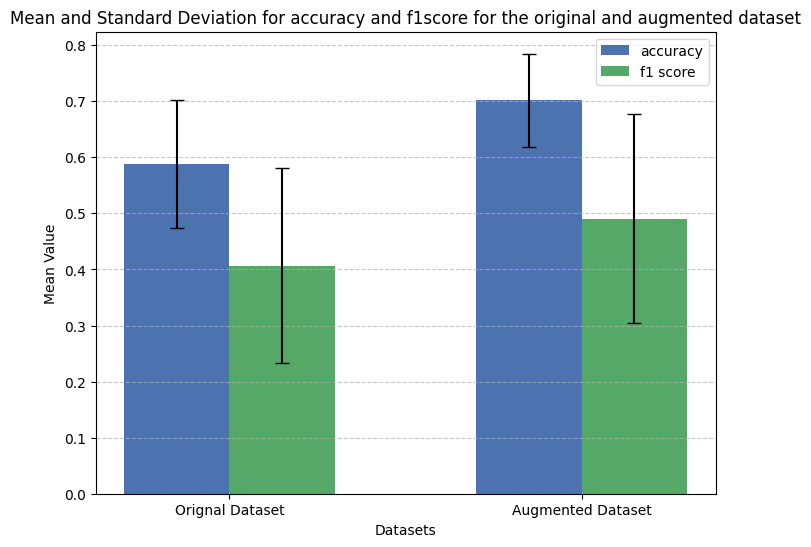

In [139]:

datasets = ['Orignal Dataset', 'Augmented Dataset']
metrics = ['accuracy', 'f1 score']

# Moyennes pour chaque métrique par dataset
means = {
    'accuracy': [acc_mean, acc_mean_aug],  # Moyenne pour Metric 1 (Dataset 1 et Dataset 2)
    'f1 score': [f1_mean, f1_mean_aug]   # Moyenne pour Metric 2 (Dataset 1 et Dataset 2)
}

# Écarts-types pour chaque métrique par dataset
stds = {
    'accuracy': [acc_std, acc_std_aug],  # Écart-type pour Metric 1 (Dataset 1 et Dataset 2)
    'f1 score': [f1_std, f1_std_aug]   # Écart-type pour Metric 2 (Dataset 1 et Dataset 2)
}

# Configuration pour le tracé
x = np.arange(len(datasets))  # Position des groupes (Dataset 1, Dataset 2)
width = 0.3  # Largeur des barres, ajustée pour éviter le chevauchement

# Création de la figure et des barres
fig, ax = plt.subplots(figsize=(8, 6))

# Barres pour Metric 1
bar1 = ax.bar(x - width/2, means['accuracy'], yerr=stds['accuracy'], 
              capsize=5, label='accuracy', color='#4C72B0', width=width)

# Barres pour Metric 2
bar2 = ax.bar(x + width/2, means['f1 score'], yerr=stds['f1 score'], 
              capsize=5, label='f1 score', color='#55A868', width=width)

# Ajout des labels et des titres
ax.set_ylabel('Mean Value')
ax.set_xlabel('Datasets')
ax.set_title('Mean and Standard Deviation for accuracy and f1score for the original and augmented dataset')
ax.set_xticks(x)
ax.set_xticklabels(datasets)
ax.legend()

# Ajout d'une grille pour plus de clarté
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Ajustement des marges pour éviter le chevauchement


# Affichage du graphique
plt.show()



In [133]:

img, mask,grt, f1 = find_best_image(device, DATA_PATH, MODEL_PATH,TRESHHOLD)
    

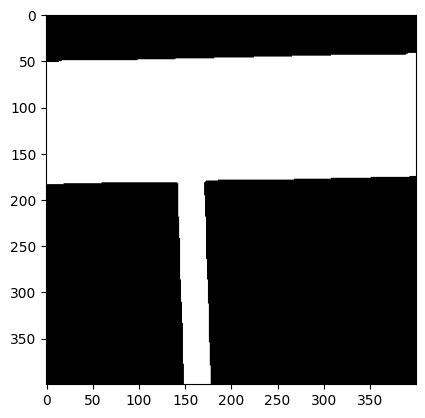

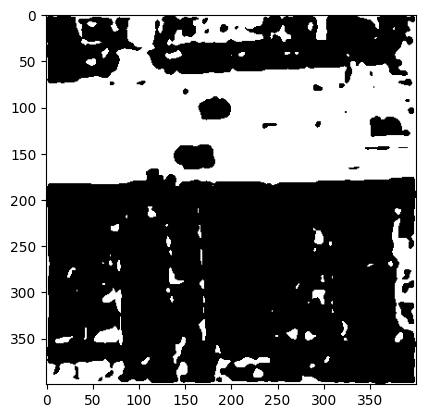

In [134]:
fig = plt.figure()
fig.add_subplot(1, 1, 1)
plt.imshow(grt, cmap="gray")
plt.show()
fig = plt.figure()
fig.add_subplot(1, 1, 1)
plt.imshow(mask, cmap="gray")
plt.show()